# Imports

In [ ]:
import sys
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage import io, filters, color, transform
import cv2 as cv
from scipy.ndimage.morphology import distance_transform_edt
from skimage.morphology import erosion, disk
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

In [ ]:
##########Założenia############
#
#1.Wszystkie litery mają tą samą, poziomą orientację 
#2.Na obrazie znajduje się tylko jedna kolumna wierszy 
###########PATH#################
page = "dasrtseldesjdisc00frit_0007"
folder_path = "drive/MyDrive/Praca_Inzynierska/pismogotyckie/dasrtseldesjdisc00frit_jp2"
read_path = folder_path + "/" + page + ".jpg"
training_path = folder_path + "/TrainingFiles/Final/60all_train_file.csv"
save_text = folder_path + "/Result/60"+page+".txt"
################Images
image_folder_path = folder_path + "/Result/Images/"

###############################

In [ ]:
# module level variables ##########################################################################
#Char 'a' size
char_heigh = 40
char_width = 15

MIN_CONTOUR_AREA = 40
MIN_CONTOUR_CHAR = char_heigh*char_width
MIN_DIST_BETWEEN_WORDS = 20 #px
DIST_BETWEN_CHARS = 1 #px
AREA_OVER_CHAR = 0.5*char_heigh

MAX_DISTANCE_KNN = 400
MAX_CHAR_CONNECT = 5
#Size of the digit
result_img_size = 60
###################################################################################################

# Functions

In [ ]:
def remove_small_element(binary_tmp, min_size):
  #find all your connected components (white blobs in your image)
  nb_components, output, stats, centroids = cv.connectedComponentsWithStats(binary_tmp, connectivity=8)
  #connectedComponentswithStats yields every seperated component with information on each of them, such as size
  #the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
  sizes = stats[1:, -1]; nb_components = nb_components - 1

  # minimum size of particles we want to keep (number of pixels)
  #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever   

  #your answer image
  binary_tmp = np.zeros((output.shape))
  #for every component in the image, you keep it only if it's above min_size
  for i in range(0, nb_components):
      if sizes[i] >= min_size:
          binary_tmp[output == i + 1] = 255
  return  binary_tmp



# Load and preprocesing Image

Number of Dimension 3


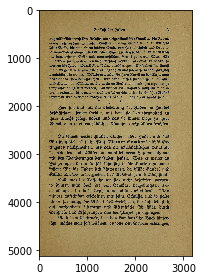

In [ ]:
digit = io.imread(read_path)
print("Number of Dimension", digit.ndim)
io.imshow(digit)
io.show()

digit


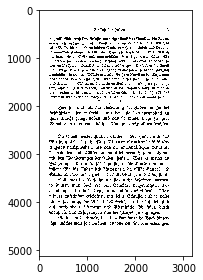

In [ ]:
if digit.ndim > 1:
    gray_image = color.rgb2gray(digit)
    print('digit')
else:
    gray_image = digit
#gray_image = cv.GaussianBlur(gray_image, (5,5), 0) 
thresh = filters.threshold_minimum(gray_image)

binary_image = gray_image > thresh
io.imshow(binary_image)
io.show()
binary = np.invert((binary_image*255).astype('uint8'))
binary_final = remove_small_element(binary, MIN_CONTOUR_AREA)
binary_final = np.invert((binary_final).astype('bool_'))

#Find line of characters, words and characters

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


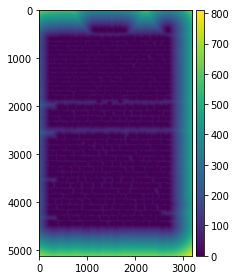

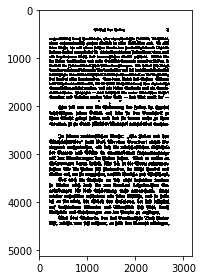

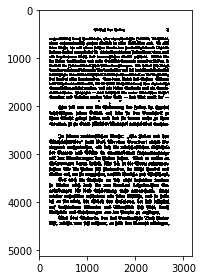

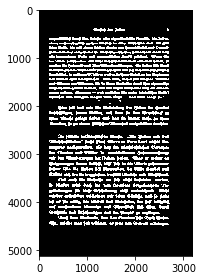

In [ ]:
dist_map = distance_transform_edt(binary_final)
tresh_dist_map = dist_map > MIN_DIST_BETWEEN_WORDS/2

io.imshow(dist_map)
io.show()
io.imshow(tresh_dist_map)
io.show()

neg_tresh_dist_map = np.invert(tresh_dist_map)
io.imshow(tresh_dist_map)
io.show()
kernel = np.ones((5,5))
#closed = cv.morphologyEx(neg_tresh_dist_map.astype('uint8'), cv.MORPH_CLOSE, kernel).astype('bool_')
mask = np.ones((MIN_DIST_BETWEEN_WORDS,1),np.uint8)
eroded = erosion(neg_tresh_dist_map, mask)
io.imshow(eroded)
io.show()

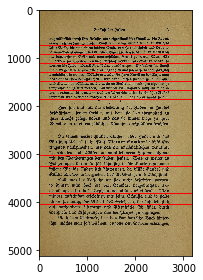

In [ ]:
eroded = (eroded*255).astype('uint8')
## (5) find and draw the upper and lower boundary of each lines
hist = cv.reduce(eroded,1, cv.REDUCE_AVG).reshape(-1)

th = 2
H,W = digit.shape[:2]
uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

digit_with_line = digit.copy()
interline = [int(uppers[0]/2)]
for i in range(1,len(uppers)):
    #cv.line(digit_with_line, (0,uppers[i]), (W, uppers[i]), (0,255,0),6)
    #cv.line(digit_with_line, (0,lowers[i]), (W, lowers[i]), (0,0,255),6)
    mid_horizontal = int((uppers[i]+lowers[i-1])/2)
    interline.append(mid_horizontal)
mid_horizontal = int(int(lowers[len(lowers)-1] + H)/2)
interline.append(mid_horizontal)

for y in interline:
    cv.line(digit_with_line, (0,y), (W, y), (255,0,0),6)

lines = []
for i in range(1, len(interline)):
  lines.append((interline[i-1], interline[i]))
io.imshow(digit_with_line)
io.show()

In [ ]:
def find_object_in_line(bin_clip, dist):
  hist = cv.reduce(bin_clip,0, cv.REDUCE_AVG).reshape(-1)

  th = 2
  H,W = bin_clip.shape[:2]
  left = [x for x in range(W-1) if hist[x]<=th and hist[x+1]>th]
  right = [x for x in range(W-1) if hist[x]>th and hist[x+1]<=th]
  if len(left) > 0 and len(right) > 0:
    mids_vertical = [int(left[0]/2)]
    for i in range(1,len(left)):
        mid_vertical = int((left[i]+right[i-1])/2)
      #if mid_vertical > dist:
        mids_vertical.append(mid_vertical)
    mid_vertical = int(int(right[len(right)-1] + W)/2)
    mids_vertical.append(mid_vertical)
    return mids_vertical
  return []

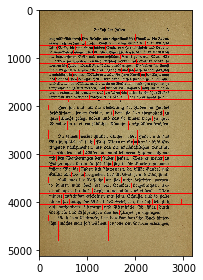

In [ ]:
digit_with_word = digit_with_line.copy()
complet_words = []
for line in lines:
  line_eroded = eroded[line[0]:line[1],:]
  interword = find_object_in_line(line_eroded, MIN_DIST_BETWEEN_WORDS)
  interword = np.sort(interword)
  word = []
  for i in range(1, len(interword)):
    word.append((interword[i-1], interword[i]))
  complet_words.append((line, word))
  for x in interword:
    cv.line(digit_with_word, (x,line[0]), (x, line[1]), (255,0,0), 4)
io.imshow(digit_with_word)
io.show()  

In [ ]:
def find_object_in_line_make_clip(bin_clip, clip):
  hist = cv.reduce(bin_clip,0, cv.REDUCE_AVG).reshape(-1)

  th = 2
  H,W = bin_clip.shape[:2]
  left = [x for x in range(W-1) if hist[x]<=th and hist[x+1]>th]
  right = [x for x in range(W-1) if hist[x]>th and hist[x+1]<=th]
  if len(left) > 0 and len(right) > 0:
    mids_vertical = [int(left[0]/2)]
    
    cv.line(clip, (int(left[0]/2),0), (int(left[0]/2), H), (255, 0,0), 2)
    for i in range(1,len(left)):
        mid_vertical = int((left[i]+right[i-1])/2)
        cv.line(clip, (mid_vertical,0), (mid_vertical, H), (255, 0, 0), 2)
        #cv.line(clip, (right[i-1],0), (right[i-1], H), (0, 0, 255), 2)
      #if mid_vertical > dist:
        mids_vertical.append(mid_vertical)
    mid_vertical = int(int(right[len(right)-1] + W)/2)
    mids_vertical.append(mid_vertical)
    return clip
  return []

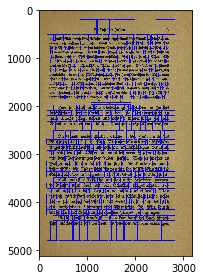

In [ ]:
digit_with_chars = digit.copy()
text_coords = []
i = 0
for line in complet_words:
  up_limit, down_limit = line[0]
  single_line = []
  i = i + 1
  #cv.putText(digit_with_chars, str(i), (10, down_limit),cv.FONT_HERSHEY_COMPLEX, 5, (0,0,255), 4, cv.LINE_AA)
  for word in line[1]: 
    word_image  = (np.invert(binary_final[up_limit:down_limit, word[0]:word[1]])*255).astype('uint8')
    interchar = find_object_in_line(word_image, DIST_BETWEN_CHARS)
    single_word = []
    for i in range(1, len(interchar)):
      char = [up_limit, down_limit, interchar[i-1]+ word[0], interchar[i]+word[0]]
      single_word.append(char)      
      
      cv.rectangle(digit_with_chars,(interchar[i-1]+ word[0],up_limit+6),(interchar[i]+word[0], down_limit-6),(0,0,255), 4)
    single_line.append(single_word)

    #for x in interchar:
    #  cv.line(digit_with_chars, (x+ word[0],up_limit), (x+word[0], down_limit), (0,255,0), 4)
  text_coords.append(single_line)
    
io.imshow(digit_with_chars)
io.show()  

# Classification

In [ ]:
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

data_train = np.loadtxt(training_path, delimiter=' ', dtype='<U32')
data_train = np.delete(data_train, 0, 0)
print("Size of the feature vector", data_train.shape)
X = data_train[:,1:]
y = data_train[:,0]
X = np.asarray(X, dtype=np.float_, order='C')
print("Size of feature vector", X.shape)
print("Size of label", y.shape)
'''
clf = RandomForestClassifier(max_depth=20, random_state=0)
clf.fit(X, y)
'''
gs = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')
gs.fit(X, y)

# create a model
'''
clf = NearestCentroid()
clf.fit(X, y)
'''

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Size of the feature vector (4401, 3601)
Size of feature vector (4401, 3600)
Size of label (4401,)


'\nclf = NearestCentroid()\nclf.fit(X, y)\n'

# Recognize single characters

In [ ]:
def img2vec(image):

    tmp_heigh, tmp_width = image.shape
    centre = ndi.measurements.center_of_mass(image)
    centre = tuple((round(tup)) for tup in centre)
    dist_row = (centre[0], tmp_heigh - centre[0])
    dist_col = (centre[1], tmp_width - centre[1])
    size = max(max(dist_row)*2, max(dist_col)*2)

    back = np.zeros((size,size), dtype=type(image[0,0]))

    row_off = round(size - max(dist_row))
    col_off = round(size - max(dist_col))
    back[round(size/2 - centre[0]): round(size/2 +  tmp_heigh - centre[0]), 
         round(size/2 - centre[1]): round(size/2 + tmp_width - centre[1])] = image
 
    #io.imsave(image_folder_path +str(i)+"clip4.png",back)
    back = (back*255).astype("uint8")    
    kernel = np.ones((3,3))
    back = cv.morphologyEx(back, cv.MORPH_DILATE, kernel).astype('bool_')
    #io.imsave(image_folder_path +str(i)+"clip5.png",(back*255).astype("uint8"))
    scale = result_img_size/size
    standard_size = transform.rescale(back, scale)
    #io.imsave(image_folder_path +str(i)+"clip6.png",(standard_size*255).astype("uint8"))
    #io.imshow(standard_size)
    #io.show()
    bool_x = standard_size.reshape((1,(result_img_size*result_img_size)))
    
    return bool_x

def recognize(data_X, tmp_img, i):
    distance,_ = gs.kneighbors(data_X)
    '''
    if np.mean(distance[0]) > MAX_DISTANCE_KNN:
        if i < MAX_CHAR_CONNECT:
            string, flag = find_more_chars(tmp_img, i+1)
        else:
            return ""
    else:
        '''
    data_y = np.array2string(gs.predict(data_X))
    begin = data_y.find('[\'') + len('[\'')
    end = data_y.find('\']')
    string = data_y[begin:end]
    return string

In [ ]:
def find_all_value(arr):
    values = arr[arr>0]
    result = []
    for value in values:
        if not result:
            result.append(value)
        elif not value in result:
            result.append(value)
    #print(result)
    return result     
def find_multi_part_char(label_objects, nb_labels):  
  #Znalezienie całego znaku
  for i in(range(1,nb_labels+1)):
    tmp = label_objects == i
    #print(i)
    rows, = np.where(tmp.sum(axis=1) > 1)
    columns, = np.where(tmp.sum(axis=0) > 1)
    if (len(rows) > 0) and (len(columns) > 0):
    
      if int(rows.max() - char_heigh*2) > 0:
        up_point = int(rows.max() - char_heigh*2)
      else:
        up_point = 0
      row_min, row_max, columns_min, columns_max = [],[],[],[] 
      row_min.append(rows.min())
      row_max.append(rows.max())
      columns_min.append(columns.min())
      columns_max.append(columns.max())
      clip = label_objects[up_point:rows.min(), columns.min():columns.max()]
      #io.imshow(clip)
      #io.show()
      #print("Layer "+str(i))
      #io.imshow(label_objects_copy[up_point:rows.max(), columns.min():columns.max()]*10)
      #io.show()
      values = find_all_value(clip)
      if len(values) > 0:
        #print("Values find " + str(i))
        for value in values:
          tmp = label_objects == value
          rows, = np.where(tmp.sum(axis=1) > 1)
          columns, = np.where(tmp.sum(axis=0) > 1)
          
          if (len(rows) > 0) & (len(columns) > 0 and (len(rows)*len(columns) < MIN_CONTOUR_CHAR*2)):
            row_min.append(rows.min())
            row_max.append(rows.max())
            columns_min.append(columns.min())
            columns_max.append(columns.max()) 
        #print("Rows")
        #print(row_min)
        #print(row_max)
        up = min(row_min)
        down = max(row_max)
        left = min(columns_min)
        right = max(columns_max)
        char = label_objects[up:down, left:right]
        mask = char > 0
        result_char = mask*i
        
        #print("Multi_part_char")
        #io.imshow(result_char)
        #io.show()
        label_objects[up:down, left:right] = result_char

  return label_objects

In [ ]:
def find_more_chars(tmp, digit_tmp, i):
    hist = cv.reduce(tmp,0, cv.REDUCE_AVG).reshape(-1)
    print(hist)
    print(len(hist))
    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])
    ax.bar( range(0, len(hist)), hist)
    ax.grid(True)
    
    plt.xlabel('Liczba pikseli obiektu w kolumnie ')
    plt.ylabel('Numer kolumny')
    plt.show()
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(image_folder_path+'tmphist.png', bbox_inches=extent.expanded(1.3, 1.3))

    flag = True
    tmp = tmp.transpose().astype('float64')
    label_objects, nb_labels = ndi.label(tmp)
    #print("In foo")
    '''
    if nb_labels > 1:        
        pass
    else:
        kernel = np.ones((3,3))
        while nb_labels <= 1:
            
            tmp = cv.erode(tmp, kernel)
            label_objects, nb_labels = ndi.label(tmp)     '''
    label_objects = label_objects.transpose()
    tmp = tmp.transpose()
    label_objects = find_multi_part_char(label_objects, nb_labels)

    chars = subs_char(label_objects, nb_labels, digit_tmp, i)  
    #io.imshow(label_objects)
    #io.show()     
    return chars, flag 
def Num_of_chars(tmp):

    label_objects, nb_labels = ndi.label(tmp)
    label_objects = find_multi_part_char(label_objects, nb_labels)
    #io.imshow(label_objects)
    #io.show()
    num_of_chars = np.unique(label_objects)
    #print(num_of_chars)
    return len(num_of_chars)-1


def split_clip(tmp,digit_tmp, num_of_chars, i):
    
    #print("")
    flag = True
    tmp = tmp.transpose().astype('float64')
    label_objects, nb_labels = ndi.label(tmp)

    kernel = np.ones((3,3))
    while nb_labels <= num_of_chars:
        
        tmp = cv.erode(tmp, kernel)
        label_objects, nb_labels = ndi.label(tmp)
    label_objects = label_objects.transpose()
    tmp = tmp.transpose()
    io.imsave(image_folder_path +str(i)+"cliperr.png",tmp)
    #io.imshow(label_objects)
    #io.show()     
    label_objects = find_multi_part_char(label_objects, nb_labels)

    chars = subs_char(label_objects, nb_labels,digit_tmp, i)  
    return chars, flag
def subs_char(label_objects, nb_labels,digit_tmp, j):
    chars = ""
    for i in(range(1,nb_labels+1)):       
        tmp = label_objects == i
        rows, = np.where(tmp.sum(axis=1) > 1)
        columns, = np.where(tmp.sum(axis=0) > 1)
        if (len(rows) > 1) and (len(columns) > 1 and (len(rows)*len(columns) > MIN_CONTOUR_AREA)):
            #print(i)
            arr = tmp[rows.min():rows.max(), columns.min():columns.max()]
            digit_arr =digit_tmp[:, columns.min():columns.max(),:]
            io.imsave(image_folder_path +str(j)+str(i)+"cliparr.png",(arr*255).astype('uint8'))                   
            io.imsave(image_folder_path +str(j)+str(i)+"cliparrdigit.png",digit_arr)   
            new_vector = img2vec(arr)
            chars = chars + recognize(new_vector, arr, i)
    return chars


In [ ]:
def find_characters(tmp, digit_tmp, i):
    string = ''
    rows, = np.where(tmp.sum(axis=1) > 0)
    columns, = np.where(tmp.sum(axis=0) > 0)
    if len(rows) > 1 and len(columns) > 1 and len(rows)*len(columns) > MIN_CONTOUR_AREA:
        tmp_img = tmp[rows.min():rows.max(), columns.min():columns.max()]
        
        #io.imsave(image_folder_path +str(i)+"clip3.png",tmp_img)
        #print(type(tmp_img[0,0]))
        vector = img2vec(tmp_img)
        distance,_ = gs.kneighbors(vector)
        label_objects_tmp, nb_labels_tmp = ndi.label(tmp_img)
        num_of_chars = Num_of_chars(tmp_img)
        #print("num_of_chars", num_of_chars, "Labels ", nb_labels_tmp-1)
        #print("Mean ", np.mean(distance[0]))
        if np.mean(distance[0]) > MAX_DISTANCE_KNN and  num_of_chars - nb_labels_tmp >= 0  and nb_labels_tmp > 1:
            
            io.imshow(tmp_img)
            io.show()
            z = input()
            if z != '':
                io.imsave(image_folder_path +str(i)+"clip3.png",tmp_img)                
                io.imsave(image_folder_path +str(i)+"clipdigit3.png",digit_tmp)
                print("num_of_chars", num_of_chars, "Labels ", nb_labels_tmp)
                print("Mean ", np.mean(distance[0]))
                string, flag = find_more_chars(tmp_img,digit_tmp, i)   
                print("Two chars in clip")             
                print(string)
                '''
        elif np.mean(distance[0]) > 600:
            io.imshow(tmp_img)
            io.show()
            z = input()
            if z != '':
                string, flag = split_clip(tmp_img ,digit_tmp, num_of_chars, i)
                io.imsave(image_folder_path +str(i)+"clipdigit3.png",digit_tmp)
                io.imsave(image_folder_path +str(i)+"clip3.png",tmp_img)
                print("num_of_chars", num_of_chars, "Labels ", nb_labels_tmp)
                print("Mean ", np.mean(distance[0]))
                print("Two chars connected")             
                print(string)
        else:
            string = recognize(vector, tmp, 0)
    '''
    #print(string)
    #io.imshow(tmp_img)
    #io.show()
    #print("##################")
    return string

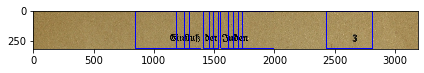

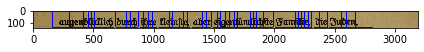

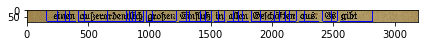

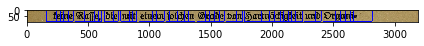

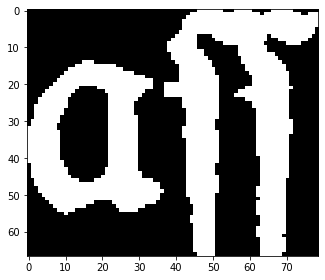

s
num_of_chars 2 Labels  2
Mean  1074.4993333333318
[ 38  61  84  99 107 114 122 129 129  95  88  69  61  57  49  53  49  49
  46  49  53  65 141 145 145 148 145 145 145 126  61  49  38  38  23  19
   4  15  27  38  46  69 103 186 206 247 240 240 232 228 225 133  34  34
  34  34  42  57  65  80  84  99 186 247 247 232 240 236 236 225 148  57
  34  34  27  27  27  23  15]
79


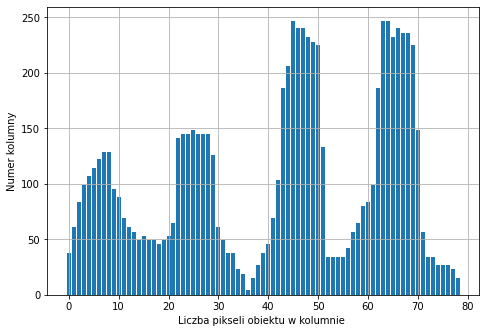

Two chars in clip
ass


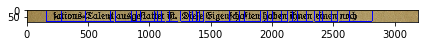

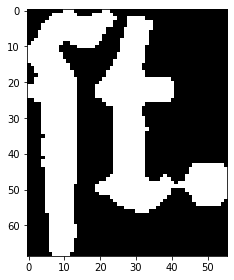

KeyboardInterrupt: ignored

In [ ]:
from skimage import  morphology
text = ""
i = 0
for num, line_coord in enumerate(text_coords, start = 0):
    line_clip = digit_with_chars[line_coord[0][0][0]:line_coord[0][0][1],:]
    io.imshow(line_clip)
    io.show()
    
    line = ""
    for word_coord in line_coord:
        word = ""
        for char_coord in word_coord:

            clip = binary_final[char_coord[0]:char_coord[1],char_coord[2]:char_coord[3]]
            digit_clip = digit[char_coord[0]:char_coord[1],char_coord[2]:char_coord[3],:]
            #io.imshow(clip)
            #io.show()
            clip = (clip*255).astype('uint8')
            #io.imsave(image_folder_path +str(i)+"clip1.png",clip)
            
            clip = remove_small_element(clip,MIN_CONTOUR_AREA)
            clip = (clip).astype('uint8')
            clip = np.invert(clip)
            clip = remove_small_element(clip,MIN_CONTOUR_AREA)
            clip = (clip).astype('uint8')
            #io.imsave(image_folder_path +str(i)+"clip2.png",clip)
            #io.imshow(clip)
            #io.show()
            chars = find_characters(clip, digit_clip, i)
            word = word + chars
            i = i + 1
            #print("Char",chars)
            #io.imshow(clip)
            #io.show()
            #print("##################")
        line = line + " " + word
    text = text + "\n" + line[1:]
d


In [ ]:
text = text.replace(",,", "\"")
text = text.replace("\"\'\"", "\"")

In [ ]:
text

'\n2 l. Einleitung\nJm Voraus sei klargestellt: religiöse Gesichtssunkte us\nBjweggründe sind hier ausgeschaltet. Der Verfassjr steht den\nreligiösdn Parteien völlig neutral gegenüber und kann sich zu\nkeiner dersdlben bjdingungslos bekennen. Wenn hier von Ju-\nden gessrochen wird, so wollen wir dabei nicht an eine Reli-\ngions.Ggmeinschast als vielmehr an jin besonderes Volk, eine\nNation, eine Rassg denken. Deshalb sei hier, wo es dsaus\nankommz dgn konfsissionellen Beigeschmack zu vfeiden, vor-\nwiegdnd der Name H ebräer oder Sem i ten gebraucht.\nDaß die suden aber, troz ihrer Zersreuung unter den\nVölkirn, sich auch heute noch als bes on dere s a ti on und\nRasse fühlsin, und daß sie s mehr als durch ihr religiöses\nBekgnntnis s sich durch ihr gemeinsamds Blut, ihre Rasse\nverbundgn fühlen, dafür mag ein Großer in Jsrael selbs\nZdugnis abljggn.\nIn seinjm Roman "Endsmion"", der 1fJ44 in London\ndrschidn, läßt Disraeli, ddr spätere englische Premier-Miniser\nLord BdaGonssield, Gine

# Saving Images, Text, Data

In [ ]:

text_file = open(save_text, "w")
text_file.write(text)
text_file.close()

In [ ]:
io.imsave(image_folder_path + page + "binary.png", binary_image*1)
binary_final = (binary_final*255).astype('uint8')
io.imsave(image_folder_path + page + "_bin_final.png",binary_final)
io.imsave(image_folder_path + page + "distance_map.png",dist_map)
tresh_dist_map = (tresh_dist_map*255).astype('uint8')
io.imsave(image_folder_path + page + "threshed_distance_map.png",tresh_dist_map)
io.imsave(image_folder_path + page + "eroded_map.png",eroded)
io.imsave(image_folder_path + page + "_line.png",digit_with_line)
io.imsave(image_folder_path + page + "_chars.png",digit_with_chars)
io.imsave(image_folder_path + page + "_word.png",digit_with_word)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: drive/MyDrive/Praca_Inzynierska/pismogotyckie/dasrtseldesjdisc00frit_jp2/Result/Images/FontTestbinary.png is a low contrast image
  """Entry point for launching an IPython kernel.


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar( range(0, len(hist)),hist)
plt.show()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(image_folder_path+'hist'+page+'.png', bbox_inches=extent.expanded(1.3, 1.2))

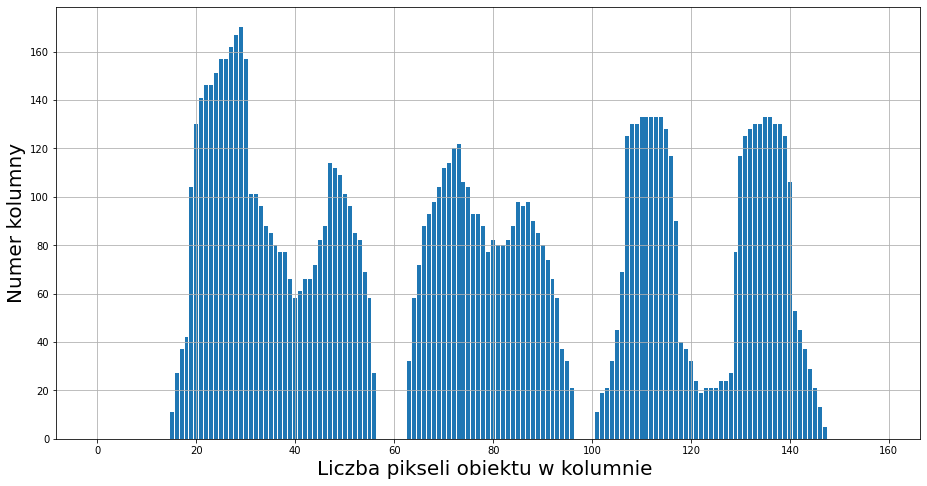

In [ ]:

hist = cv.reduce(tmp_test,0, cv.REDUCE_AVG).reshape(-1)
fig = plt.figure(figsize=(12, 6))

ax = fig.add_axes([0,0,1,1])
ax.bar( range(0, len(hist)), hist)
ax.grid(True)

plt.xlabel('Liczba pikseli obiektu w kolumnie ',fontsize=20)
plt.ylabel('Numer kolumny',fontsize=20)
plt.show()
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(image_folder_path+'histgood.png', bbox_inches=extent.expanded(1.3, 1.3))